In [69]:
%matplotlib inline
! realpath IKT450
from google.colab import drive
drive.mount('/content/gdrive')
!ls /content/gdrive/MyDrive
! git clone https://github.com/JoarVarpe/IKT450.git
!nvidia-smi

from collections import Counter
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
import glob
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision
from sklearn.neighbors import KNeighborsClassifier
import sys

random.seed(7)

/content/IKT450
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
 20201124_025526.jpg			     res_50_10.pt
 Candito+Linear+Program.pdf		     res_50_15.pt
 classifier0.pt				     res_50_17.pt
 classifier12.pt			     res_50_19.pt
 classifier13.pt			     res_50_1.pt
 classifier14.pt			     res_50_20.pt
 classifier16.pt			     res_50_25.pt
 classifier1.pt				     res_50_2.pt
 classifier2.pt				     res_50_30.pt
 classifier3.pt				     res_50_35.pt
 classifier4.pt				     res_50_38.pt
 classifier5.pt				     res_50_39.pt
 classifier6.pt				     res_50_3.pt
 classifier7.pt				     res_50_40.pt
 classifier_body0.pt			     res_50_45.pt
 classifier_body11.pt			     res_50_48.pt
 classifier_body1.pt			     res_50_49.pt
 classifier_body2.pt			     res_50_50.pt
 classifier_body3.pt			     res_50_55.pt
 classifier_body5.pt			     res_50_5.pt
'Colab Notebooks'			     res_50_60.pt
'Husleieavtale Joar Varpe 2-1 signert.pd

In [70]:
class Config():
    training_dir = "/content/IKT450/0_8/train/"
    testing_dir = "/content/IKT450/0_8/test/"
    training_dir_body = "/content/IKT450/0_8_body/train/"
    testing_dir_body = "/content/IKT450/0_8_body/test/"
    train_batch_size = 3
    train_number_epochs = 100

In [71]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [72]:
folder_dataset_train = dset.ImageFolder(root=Config.training_dir)
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)


In [73]:
class SiameseNetworkDataset(Dataset):

    def __init__(self, imageFolderDataset, single_img=False, percent_same=None, transform=None, fixed=False):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
        self.percent_same = percent_same
        self.single_img = single_img
        self.fixed = fixed
        print(self.percent_same)

        n_imgs = len(self)
        self.test_order = list(range(n_imgs))
        random.shuffle(self.test_order)

    def __getitem__(self, index):
        if self.single_img:
            return self.imageFolderDataset.imgs[index]
        else:
            # img0_tuple = random.choice(self.imageFolderDataset.imgs)
            img0_tuple = self.imageFolderDataset.imgs[index]
            if self.fixed:
                img1_tuple = self.imageFolderDataset.imgs[self.test_order[index]]
                img0 = Image.open(img0_tuple[0])
                img1 = Image.open(img1_tuple[0])

                if self.transform is not None:
                    img0 = self.transform(img0)
                    img1 = self.transform(img1)

                return img0, img1, img0_tuple, img1_tuple, torch.from_numpy(
                    np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))

            # we need to make sure approx 50% of images are in the same class
            if self.percent_same != None:
                should_get_same_class = self.percent_same
            else:

                should_get_same_class = random.randint(0, 1)

            if should_get_same_class:
                while True:
                    # keep looping till the same class image is found
                    img1_tuple = random.choice(self.imageFolderDataset.imgs)
                    if img0_tuple[1] == img1_tuple[1]:
                        break
            else:
                while True:
                    # keep looping till a different class image is found

                    img1_tuple = random.choice(self.imageFolderDataset.imgs)
                    if img0_tuple[1] != img1_tuple[1]:
                        break

            img0 = Image.open(img0_tuple[0])
            img1 = Image.open(img1_tuple[0])

            if self.transform is not None:
                img0 = self.transform(img0)
                img1 = self.transform(img1)

            return img0, img1, img0_tuple, img1_tuple, torch.from_numpy(
                np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [74]:
siamese_dataset_train = SiameseNetworkDataset(imageFolderDataset=folder_dataset_train,
                                        transform=preprocess)
siamese_dataset_test = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=preprocess)

None
None


In [75]:
train_dataloader = DataLoader(siamese_dataset_train,
                        shuffle=True,
                        num_workers=8,
                        batch_size=1)#Config.train_batch_size)

test_dataloader = DataLoader(siamese_dataset_test,
                        shuffle=True,
                        num_workers=8,
                        batch_size=1)#Config.train_batch_size)

In [129]:
import tqdm
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
model.fc = torch.nn.Linear( in_features=2048,out_features=128) #res50
model_save_name = 'res_50_1.pt' 
path = F"/content/gdrive/My Drive/{model_save_name}"
model.load_state_dict(torch.load(path, map_location=lambda storage, loc: storage))
model.eval()
# model.cuda()

list_of_all_1 = []
list_of_all_2 = []

for batch in tqdm.tqdm(test_dataloader):
    img0, img1,  img0_info, img1_info, label = batch
    with torch.no_grad():
        # enc0 = model(img0.cuda()).cpu()
        enc0 = model(img0)
        list_of_all_1.append(enc0)
        list_of_all_2.append(img0_info)



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0

100%|██████████| 423/423 [01:47<00:00,  3.95it/s]


In [130]:
list_of_labels = []
for i in range(len(list_of_all_2)):
    path = list_of_all_2[i][0][0]
    single_path_list = path.split("/")
    label = single_path_list[5]
    list_of_labels.append(label)



In [131]:
from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('euclidean')

data = np.array([d.numpy()  for d in list_of_all_1])[:, 0, :]
data.shape
d_mat = dist.pairwise(data)
np.fill_diagonal(d_mat, 1e10)
top1 = d_mat.argmin(axis=1)
print(list_of_all_2)

correct = 0
total = 0
for k, answer in enumerate(list_of_labels):
    if answer == list_of_labels[top1[k]]:
        correct += 1
    total += 1


print(correct, total)
print("top1 accuracy: ", correct / (correct + total))

[[('/content/IKT450/0_8/test/431397/431397_l_2.jpg',), tensor([67])], [('/content/IKT450/0_8/test/433405/433405_l_1.jpg',), tensor([77])], [('/content/IKT450/0_8/test/423301/423301_r_1.jpg',), tensor([44])], [('/content/IKT450/0_8/test/431600/431600_r_1.jpg',), tensor([70])], [('/content/IKT450/0_8/test/422191/422191_r_1.jpg',), tensor([35])], [('/content/IKT450/0_8/test/423291/423291_l_2.jpg',), tensor([43])], [('/content/IKT450/0_8/test/433405/433405_r_2.jpg',), tensor([77])], [('/content/IKT450/0_8/test/443062/443062_l_2.jpg',), tensor([88])], [('/content/IKT450/0_8/test/421665/421665_l_3.jpg',), tensor([25])], [('/content/IKT450/0_8/test/426553/426553_l_1.jpg',), tensor([62])], [('/content/IKT450/0_8/test/421189/421189_l_2.jpg',), tensor([12])], [('/content/IKT450/0_8/test/443334/443334_r_1.jpg',), tensor([91])], [('/content/IKT450/0_8/test/424216/424216_l_4.jpg',), tensor([49])], [('/content/IKT450/0_8/test/423747/423747_r_1.jpg',), tensor([45])], [('/content/IKT450/0_8/test/44378

top5 acc:  0.2293144208037825
res_50_1.pt
mean:  36.981087470449175
median:  16.0
counts.std()  52.86831512324818
counts.max()  380
counts.min()  1


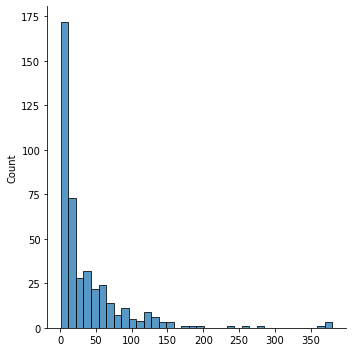

In [144]:
guess_count = []
ranks = d_mat.argsort(axis=1)
for k, answer in enumerate(list_of_labels):

    for i in range(ranks.shape[0]):
        if answer == list_of_labels[ranks[k, i]]:
            guess_count.append(i + 1)
            break


"""
test data used ++++++++++++++++++++++++++++++++++++++++
pure guessing accuracy for test set 0.002364066193853428

top1 accuracy:  0.03644646924829157
top5 acc:  0.2293144208037825
res_50_1.pt flipped
mean:  36.981087470449175
median:  16.0
counts.std()  52.86831512324818
counts.max()  380
counts.min()  1

top1 accuracy:  0.10947368421052632
top5 acc:  0.34988179669030733
res_50_88.pt flipped
mean:  17.555555555555557
median:  9.0
counts.std()  30.735677994147384
counts.max()  342
counts.min()  1

top1 accuracy:  0.12422360248447205
top5 acc:  0.41371158392434987
res_50_100+7.pt flipped
mean:  15.784869976359339
median:  8.0
counts.std()  26.765394508327418
counts.max()  294
counts.min()  1
"""
counts_raw = np.array(guess_count)
counts = counts_raw.copy()
top5 = counts_raw.copy()
labels1 = counts_raw.copy()
labels5 = counts_raw.copy()
labels1[counts_raw >= 32] = 6
labels1[counts_raw < 32] = 5
labels1[counts_raw < 16] = 4
labels1[counts_raw < 8] = 3
labels1[counts_raw < 4] = 2
labels1[counts_raw < 2] = 1

# labels1[labels1>1] = 2
# labels5[labels5<=5] = 5
# labels5[labels5>5] = 6
top5[top5<=5] = 1
top5[top5>5] = 0
print("top5 acc: ", top5.mean())
# counts[counts>600] = 600
print(model_save_name)
print("mean: ", counts.mean())
print("median: ", np.median(counts))
print("counts.std() ", counts.std())
print("counts.max() ", counts.max())
print("counts.min() ", counts.min())

import seaborn as sns
sns.displot(counts)

In [134]:
print(1/len(counts), len(counts))


0.002364066193853428 423


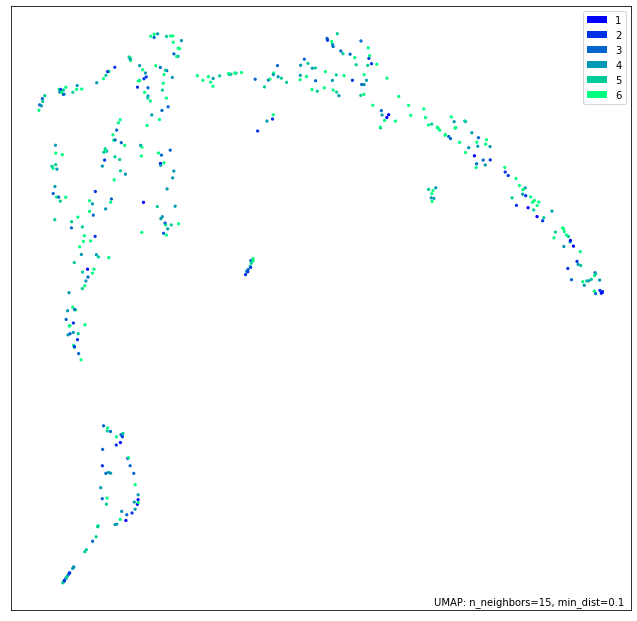

In [145]:
import umap
import umap.plot
mapper = umap.UMAP().fit(data)
# for c in  [
#             'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
#             'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
#             'hot', 'afmhot', 'gist_heat', 'copper']:
#     print(c)
umap.plot.points(mapper, labels=labels1, color_key_cmap="winter")
# umap.plot.points(mapper, labels=labels1, color_key_cmap='autumn')



In [ ]:
!nvidia-smi

Wed Dec  2 09:19:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    33W / 250W |  16279MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!ps -aux|grep python

root          49  0.2  0.4 195440 60936 ?        Sl   09:01   0:02 /usr/bin/python2 /usr/local/bin/jupyter-notebook --ip="172.28.0.2" --port=9000 --FileContentsManager.root_dir="/" --LargeFileManager.delete_to_trash=False --MappingKernelManager.root_dir="/content"
root         224  0.0  0.0  18384  3044 ?        S    09:04   0:00 bash -c tail -n +0 -F "/root/.config/Google/DriveFS/Logs/drive_fs.txt" | python3 /opt/google/drive/drive-filter.py > "/root/.config/Google/DriveFS/Logs/timeouts.txt" 
root         226  0.0  0.0  29216  9400 ?        S    09:04   0:00 python3 /opt/google/drive/drive-filter.py
root         330  1.7 21.8 33576060 2917564 ?    Ssl  09:08   0:11 /usr/bin/python3 -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-6ae9d015-846c-4398-863b-24d058930b96.json
root         538  0.0  0.0  39204  6568 ?        S    09:19   0:00 /bin/bash -c ps -aux|grep python
root         540  0.0  0.0  38580  5644 ?        S    09:19   0:00 grep python


In [ ]:
!kill 330

In [146]:
507 * 0.2


101.4